In [5]:
import torch
torch.cuda.empty_cache()
import torch.nn as nn
from torchinfo import summary
import torch.optim as optim
import numpy as np
import h5py
import os
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [6]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.current_device())  # Should print the device index (e.g., 0)
print(torch.cuda.get_device_name(0))  # S

True
0
NVIDIA GeForce RTX 3050 Laptop GPU


In [7]:
class GanglionCellDataset(Dataset):
    def __init__(self, h5_file):
        
        self.h5_file = h5_file
        with h5py.File(h5_file, 'r') as f:
            self.stimuli = np.array(f['train/stimulus'])  # (359802, 50, 50)
            self.responses = np.array(f['train/response/firing_rate_10ms'])  # (9, 359802)

        # Reshape stimuli to (N, 1, H, W) for CNN
        self.stimuli = self.stimuli[:, np.newaxis, :, :].astype(np.float32)  # (359802, 1, 50, 50)

        # Transpose responses to match sample dimension
        self.responses = self.responses.T.astype(np.float32)  # (359802, 9)

    def __len__(self):
        return len(self.stimuli)

    def __getitem__(self, idx):
        stimuli = torch.tensor(self.stimuli[idx], device=DEVICE)  # Move to device
        responses = torch.tensor(self.responses[idx], device=DEVICE)  # Move to device
        return stimuli, responses

In [8]:
class GaussianNoise(nn.Module):
    def __init__(self, std: float):
        super(GaussianNoise, self).__init__()
        self.std = std

    def forward(self, x):
        if self.training:  # Only apply noise during training
            noise = torch.randn_like(x).to(x.device) * self.std  # Ensure noise is on the same device
            return x + noise
        return x

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)  # Flatten the input tensor

class Exponential(nn.Module):
    def __init__(self, train_off=False):
        super(Exponential, self).__init__()
        self.train_off = train_off

    def forward(self, x):
        if self.train_off:
            return torch.exp(x)  # Example: Exponential activation without training
        else:
            return torch.exp(x)  # Modify as needed based on the desired behavior

In [9]:
class TDRModel(nn.Module):
    """
    Base class for most models. Handles setting most of the member
    variables that are shared for most model definitions.
    """
    def __init__(self, n_units=5, noise=.05, bias=True, gc_bias=None,
                 chans=[8,8], bn_moment=.01, softplus=True,
                 inference_exp=False, img_shape=(40,50,50),
                 ksizes=(15,11,11), recurrent=False, kinetic=False,
                 convgc=False, centers=None, bnorm_d=1,
                 activ_fxn='ReLU', **kwargs):
        """
        Initializes common parameters for retinal models.
        """
        super().__init__()
        self.n_units = n_units
        self.chans = chans
        self.softplus = softplus
        self.infr_exp = inference_exp
        self.bias = bias
        self.img_shape = img_shape
        self.ksizes = ksizes
        self.gc_bias = gc_bias
        self.noise = noise
        self.bn_moment = bn_moment
        self.recurrent = recurrent
        self.kinetic = kinetic
        self.convgc = convgc
        self.centers = centers
        self.bnorm_d = bnorm_d
        assert bnorm_d in [1, 2], "Only 1D and 2D batchnorm are supported."
        self.activ_fxn = activ_fxn

    def forward(self, x):
        """
        This function should be implemented in child classes.
        """
        raise NotImplementedError("Forward function must be implemented in child class.")

    def update_shape(self, shape, kernel_size):
        """
        Helper function to update spatial dimensions after convolution.

        Parameters:
        - shape: tuple (height, width)
        - kernel_size: int or tuple

        Returns:
        - New shape after convolution
        """
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        h_out = shape[0] - kernel_size[0] + 1
        w_out = shape[1] - kernel_size[1] + 1
        return (h_out, w_out)

    def extra_repr(self):
        """
        This function is used in model printing. Shows model parameters.
        """
        s = ['n_units={}', 'noise={}', 'bias={}', 'gc_bias={}',
             'chans={}', 'bn_moment={}', 'softplus={}',
             'inference_exp={}', 'img_shape={}', 'ksizes={}']
        return ", ".join(s).format(self.n_units, self.noise, self.bias,
                                   self.gc_bias, self.chans,
                                   self.bn_moment, self.softplus,
                                   self.infr_exp, self.img_shape, self.ksizes)

    def requires_grad(self, state: bool):
        """
        Enables or disables gradient calculations.

        Parameters:
        - state (bool): True to enable gradients, False to disable.
        """
        for p in self.parameters():
            p.requires_grad = state

In [10]:
# Exact BNCNN Model
class BNCNN(TDRModel):
    """
    BatchNorm CNN for predicting ganglion cell responses.
    """

    def __init__(self, gauss_prior=0, **kwargs):
        super().__init__(**kwargs)
        self.name = 'McNiruNet'
        self.gauss_prior = gauss_prior
        modules = []
        self.shapes = []
        shape = self.img_shape[1:]

        modules.append(nn.Conv2d(self.img_shape[0], self.chans[0], kernel_size=self.ksizes[0], bias=self.bias))
        shape = self.update_shape(shape, self.ksizes[0])
        self.shapes.append(tuple(shape))

        if self.bnorm_d == 1:
            modules.append(Flatten())
            size = self.chans[0] * shape[0] * shape[1]
            modules.append(nn.BatchNorm1d(size, eps=1e-3, momentum=self.bn_moment))
            modules.append(Reshape((-1, self.chans[0], *shape)))
        else:
            modules.append(nn.BatchNorm2d(self.chans[0], eps=1e-3, momentum=self.bn_moment))

        modules.append(GaussianNoise(std=self.noise))
        modules.append(getattr(nn, self.activ_fxn)())

        modules.append(nn.Conv2d(self.chans[0], self.chans[1], kernel_size=self.ksizes[1], bias=self.bias))
        shape = self.update_shape(shape, self.ksizes[1])
        self.shapes.append(tuple(shape))

        if self.bnorm_d == 1:
            modules.append(Flatten())
            size = self.chans[1] * shape[0] * shape[1]
            modules.append(nn.BatchNorm1d(size, eps=1e-3, momentum=self.bn_moment))
            modules.append(Reshape((-1, self.chans[1], shape[0], shape[1])))
        else:
            modules.append(nn.BatchNorm2d(self.chans[1], eps=1e-3, momentum=self.bn_moment))

        modules.append(GaussianNoise(std=self.noise))
        modules.append(getattr(nn, self.activ_fxn)())

        if self.convgc:
            modules.append(nn.Conv2d(self.chans[1], self.n_units, kernel_size=self.ksizes[2], bias=self.gc_bias))
            shape = self.update_shape(shape, self.ksizes[2])
            self.shapes.append(tuple(shape))
            modules.append(GrabUnits(self.centers, self.ksizes, self.img_shape))
        else:
            modules.append(Flatten())
            size = self.chans[1] * shape[0] * shape[1]
            modules.append(nn.Linear(size, self.n_units, bias=self.gc_bias))

        modules.append(nn.BatchNorm1d(self.n_units, eps=1e-3, momentum=self.bn_moment))

        if self.softplus:
            modules.append(nn.Softplus())
        else:
            modules.append(Exponential(train_off=True))

        self.sequential = nn.Sequential(*modules)

        if self.gauss_prior > 0:
            for i, seq_idx in enumerate([0, 6]):
                weight = self.sequential[seq_idx].weight
                filters = []
                for out_i in range(weight.shape[0]):
                    kernels = []
                    for in_i in range(weight.shape[1]):
                        prior_x = signal.gaussian(weight.shape[-1], std=self.gauss_prior)
                        prior_y = signal.gaussian(weight.shape[-2], std=self.gauss_prior)
                        prior = np.outer(prior_y, prior_x)
                        kernels.append(prior)
                    filters.append(np.asarray(kernels))
                prior = np.asarray(filters)
                denom = np.sqrt(weight.shape[0] + weight.shape[1])
                prior = prior / np.max(prior) / denom
                prior = torch.FloatTensor(prior)
                self.sequential[seq_idx].weight.data = prior

    def forward(self, x):
        if not self.training and self.infr_exp:
            return torch.exp(self.sequential(x))
        return self.sequential(x)

In [11]:
def train_model(h5_file, hyperparams, batch_size=32, lr=0.01, epochs=2, val_split=0.1):
    dataset = GanglionCellDataset(h5_file)
    train_size = int((1 - val_split) * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    model = BNCNN(**hyperparams).to(DEVICE)
    loss_fn = nn.PoissonNLLLoss(log_input=False)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    writer = SummaryWriter(log_dir="runs/bncnn_experiment")

    loss_history, accuracy_history = [], []
    val_loss_history, val_accuracy_history = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, train_acc, train_count = 0, 0, 0
        all_predictions, all_targets = [], []

        for stimuli, firing_rate in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            stimuli, firing_rate = stimuli.to(DEVICE), firing_rate.to(DEVICE)
            optimizer.zero_grad()
            predictions = model(stimuli)
            loss = loss_fn(predictions, firing_rate)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pred_np, target_np = predictions.detach().cpu().numpy(), firing_rate.detach().cpu().numpy()
            
            correlations = [
                np.corrcoef(pred_np[:, i], target_np[:, i])[0, 1] if np.std(pred_np[:, i]) > 0 and np.std(target_np[:, i]) > 0 else 0
                for i in range(9)
            ]
            correlation = np.mean(correlations)
            train_acc += correlation
            train_count += 1
            all_predictions.append(pred_np)
            all_targets.append(target_np)

        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_acc / train_count if train_count > 0 else 0
        loss_history.append(avg_train_loss)
        accuracy_history.append(avg_train_acc)
        writer.add_scalar("Loss/train", avg_train_loss, epoch)
        writer.add_scalar("Accuracy/train", avg_train_acc, epoch)

        model.eval()
        val_loss, val_acc, val_count = 0, 0, 0
        all_val_predictions, all_val_targets = [], []

        with torch.no_grad():
            for stimuli, firing_rate in val_loader:
                stimuli, firing_rate = stimuli.to(DEVICE), firing_rate.to(DEVICE)
                predictions = model(stimuli)
                loss = loss_fn(predictions, firing_rate)
                val_loss += loss.item()
                
                pred_np, target_np = predictions.cpu().numpy(), firing_rate.cpu().numpy()
                correlations = [
                    np.corrcoef(pred_np[:, i], target_np[:, i])[0, 1] if np.std(pred_np[:, i]) > 0 and np.std(target_np[:, i]) > 0 else 0
                    for i in range(9)
                ]
                correlation = np.mean(correlations)
                val_acc += correlation
                val_count += 1
                all_val_predictions.append(pred_np)
                all_val_targets.append(target_np)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_acc / val_count if val_count > 0 else 0
        val_loss_history.append(avg_val_loss)
        val_accuracy_history.append(avg_val_acc)
        writer.add_scalar("Loss/val", avg_val_loss, epoch)
        writer.add_scalar("Accuracy/val", avg_val_acc, epoch)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Train Acc: {avg_train_acc:.4f}, "
              f"Val Loss: {avg_val_loss:.6f}, Val Acc: {avg_val_acc:.4f}")

    torch.save(model.state_dict(), "bncnn_model.pth")
    print("Model saved to bncnn_model.pth")

    channels, height, width = 1, 50, 50
    # Print model summary
    summary_str = str(summary(model, input_size=(batch_size, 1, 50, 50), depth=10, verbose=2))
    # print(summary_str)

    all_predictions = np.vstack(all_predictions)
    all_targets = np.vstack(all_targets)
    all_val_predictions = np.vstack(all_val_predictions)
    all_val_targets = np.vstack(all_val_targets)
    
    print(f"Final Training Loss: {loss_history[-1]:.6f}")
    print(f"Final Training Accuracy: {accuracy_history[-1]:.4f}")
    print(f"Final Validation Loss: {val_loss_history[-1]:.6f}")
    print(f"Final Validation Accuracy: {val_accuracy_history[-1]:.4f}")
    print(f"Shape of final training prediction array: {all_predictions.shape}")
    print(f"Shape of final training actual array: {all_targets.shape}")
    print(f"Shape of final validation prediction array: {all_val_predictions.shape}")
    print(f"Shape of final validation actual array: {all_val_targets.shape}")

    
    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), loss_history, label="Train Loss")
    plt.plot(range(epochs), val_loss_history, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")
    
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), accuracy_history, label="Train Accuracy")
    plt.plot(range(epochs), val_accuracy_history, label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Correlation")
    plt.legend()
    plt.title("Accuracy Curve")
    plt.show()
    
    return {
        'model': model,
        'loss_history': loss_history,
        'accuracy_history': accuracy_history,
        'val_loss_history': val_loss_history,
        'val_accuracy_history': val_accuracy_history,
        'all_predictions': all_predictions,
        'all_targets': all_targets,
        'all_val_predictions': all_val_predictions,
        'all_val_targets': all_val_targets
    }

Epoch 1/2: 100%|██████████| 10120/10120 [05:42<00:00, 29.54it/s]


Epoch 1/2, Train Loss: -0.140334, Train Acc: 0.1240, Val Loss: -0.224952, Val Acc: 0.1425


Epoch 2/2: 100%|██████████| 10120/10120 [04:08<00:00, 40.80it/s]


Epoch 2/2, Train Loss: -0.428084, Train Acc: 0.1886, Val Loss: -0.587086, Val Acc: 0.2176
Model saved to bncnn_model.pth
Layer (type:depth-idx)                   Output Shape              Param #
BNCNN                                    [32, 9]                   --
├─Sequential: 1-1                        [32, 9]                   --
│    └─0.weight                                                    ├─800
│    └─0.bias                                                      ├─32
│    └─1.weight                                                    ├─32
│    └─1.bias                                                      ├─32
│    └─4.weight                                                    ├─51,200
│    └─4.bias                                                      ├─64
│    └─5.weight                                                    ├─64
│    └─5.bias                                                      ├─64
│    └─9.weight                                                    ├─1,016,064
│   

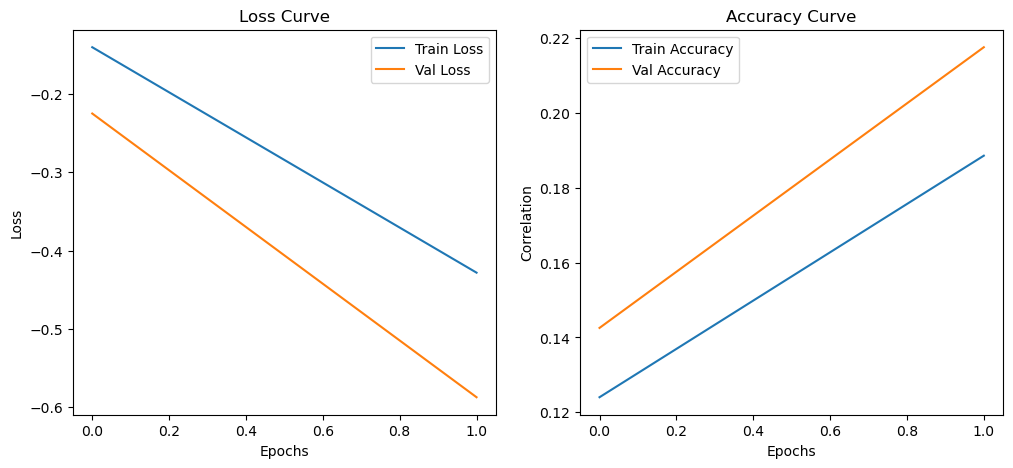

In [12]:
# Define Hyperparameters
hyperparams = {
    'img_shape': (1, 50, 50),
    'chans': [8, 8],
    'ksizes': [15, 12, 9],
    'bias': True,
    'bnorm_d': 2,
    'bn_moment': 0.01,
    'noise': 0.05,
    'activ_fxn': 'ReLU',
    'n_units': 9,
    'gc_bias': False,
    'softplus': True,
    'convgc': False,
    'centers': None
}

h5_path = r'C:\Users\krmri\Downloads\neural_code_data\neural_code_data\ganglion_cell_data\15-10-07\naturalscene.h5'
results = train_model(h5_path, hyperparams)

In [3]:
def plot_neuron_predictions(results):
    """Separate function to plot neuron predictions"""
    # Plot True vs. Predicted for 9 neurons (training data)
    print("\nPlotting training data predictions:")
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    time_steps = np.arange(results['all_targets'].shape[0])  
    
    for i, ax in enumerate(axes.flat):
        ax.plot(time_steps, results['all_targets'][:, i], label="True", linestyle="-", color="blue", alpha=0.7)
        ax.plot(time_steps, results['all_predictions'][:, i], label="Predicted", linestyle="--", color="red", alpha=0.7)
        
        ax.set_xlabel("Time (Image Index)")
        ax.set_ylabel("Firing Rate")
        ax.set_title(f"Neuron {i+1} (Training)")
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot True vs. Predicted for 9 neurons (validation data)
    print("\nPlotting validation data predictions:")
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    time_steps = np.arange(results['all_val_targets'].shape[0])  
    
    for i, ax in enumerate(axes.flat):
        ax.plot(time_steps, results['all_val_targets'][:, i], label="True", linestyle="-", color="blue", alpha=0.7)
        ax.plot(time_steps, results['all_val_predictions'][:, i], label="Predicted", linestyle="--", color="red", alpha=0.7)
        
        ax.set_xlabel("Time (Image Index)")
        ax.set_ylabel("Firing Rate")
        ax.set_title(f"Neuron {i+1} (Validation)")
        ax.legend()
    
    plt.tight_layout()
    plt.show()
# plot_neuron_predictions(results)

In [2]:
import json

def save_training_results(results, filename="training_results.json"):
    # Create a copy to avoid modifying the original
    results_to_save = results.copy()
    
    # Remove the model (can't be JSON-serialized)
    model = results_to_save.pop('model')  # Save separately with torch.save
    
    # Convert numpy arrays to lists
    for key, value in results_to_save.items():
        if isinstance(value, np.ndarray):
            results_to_save[key] = value.tolist()
    
    # Save to JSON file
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(results_to_save, f, indent=4)  # indent=4 for readability
    
    print(f"Results saved to {filename} (excluding model)")

# Example usage after training:
save_training_results(results)

NameError: name 'results' is not defined

In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt

def load_training_results(filename="training_results.json"):
    """Load training results from JSON file and convert lists back to numpy arrays"""
    with open(filename, 'r', encoding='utf-8') as f:
        results = json.load(f)
    
    # Convert lists back to numpy arrays for the prediction/target data
    array_keys = ['all_predictions', 'all_targets', 'all_val_predictions', 'all_val_targets']
    for key in array_keys:
        if key in results:
            results[key] = np.array(results[key])
    
    return results


Plotting training data predictions:


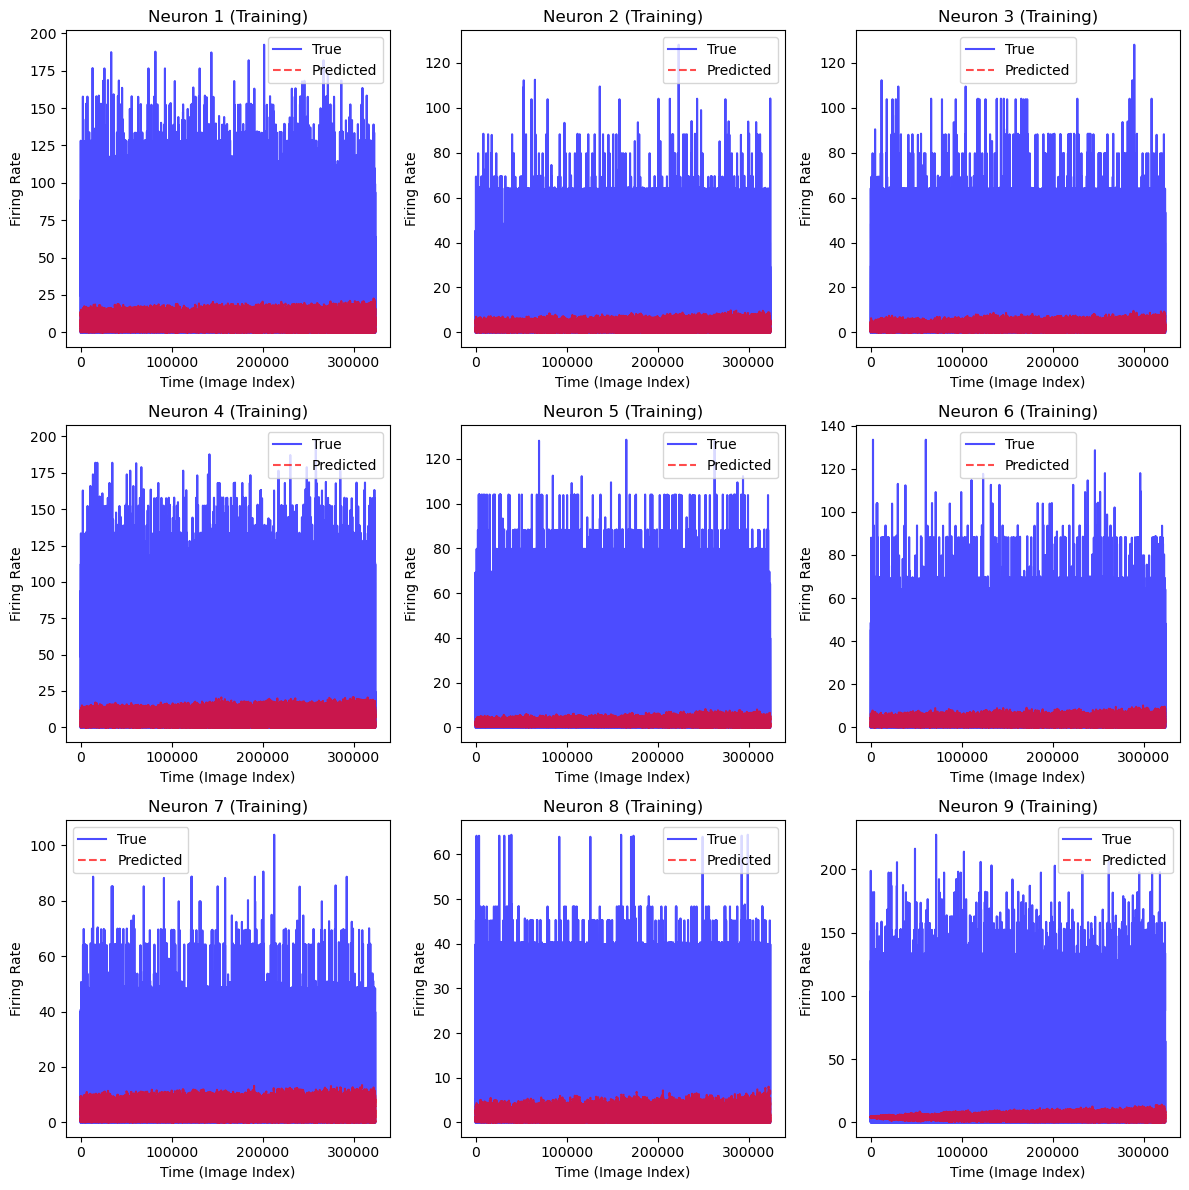


Plotting validation data predictions:


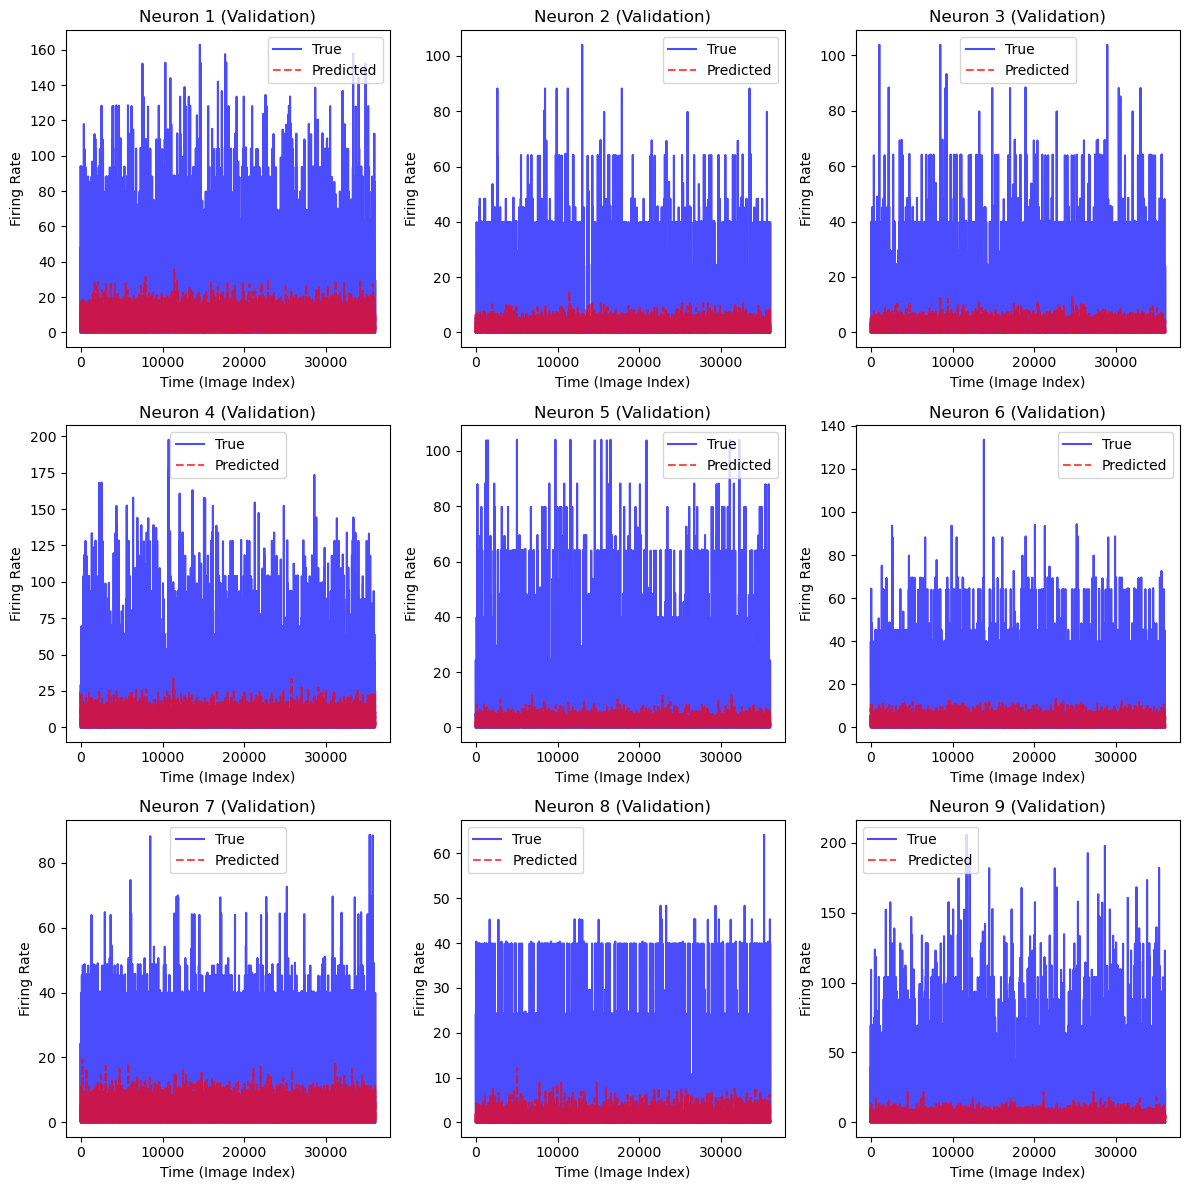

In [5]:
# Load the saved results
loaded_results = load_training_results("training_results.json")

# Pass to your plotting function
plot_neuron_predictions(loaded_results)